<a href="https://www.kaggle.com/code/danish2op/nn-for-mnist?scriptVersionId=182860102" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) 


In [3]:
data_dev = data[0:28000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

In [4]:
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [5]:
def init_params():
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(64, 128) - 0.5
    b2 = np.random.rand(64, 1) - 0.5
    W3 = np.random.rand(10, 64) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2, W3, b3




In [6]:
# Activation functions and their derivatives
def LeakyReLU(Z, alpha=0.01):
    return np.maximum(alpha * Z, Z)

def ELU(Z, alpha=1.0):
    return np.where(Z > 0, Z, alpha * (np.exp(Z) - 1))

def ReLU(Z):
    return np.maximum(0, Z)

def LeakyReLU_deriv(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

def ELU_deriv(Z, alpha=1.0):
    return np.where(Z > 0, 1, alpha * np.exp(Z))

def ReLU_deriv(Z):
    return np.where(Z > 0, 1, 0)

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_deriv(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))


In [7]:
def forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2):
    Z1 = W1.dot(X) + b1
    A1 = activation_hidden1(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = activation_hidden2(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3


In [8]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


In [9]:
def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, activation_hidden1_deriv, activation_hidden2_deriv):
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = W3.T.dot(dZ3) * activation_hidden2_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * activation_hidden1_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2, dW3, db3


In [10]:
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3


In [11]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size


In [12]:
def gradient_descent(X, Y, alpha, iterations, activation_hidden1, activation_hidden2, activation_hidden1_deriv, activation_hidden2_deriv):
    W1, b1, W2, b2, W3, b3 = init_params()
    accuracy_list = []
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, activation_hidden1_deriv, activation_hidden2_deriv)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 10 == 0:
            predictions = np.argmax(A3, axis=0)
            accuracy = get_accuracy(predictions, Y)
            accuracy_list.append(accuracy)
            print(f"Iteration {i}: {accuracy}")
    return W1, b1, W2, b2, W3, b3, accuracy_list


In [13]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, activation_hidden1, activation_hidden2):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2)
    predictions = np.argmax(A3, axis=0)
    return predictions


In [14]:
print("training with LeakyReLU and ELU")
W1, b1, W2, b2, W3, b3, accuracy_list_leaky_elu = gradient_descent(
    X_dev, Y_dev, 0.10, 500, LeakyReLU, ELU, LeakyReLU_deriv, ELU_deriv)

predictions_test_leaky_elu = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, LeakyReLU, ELU)


training with LeakyReLU and ELU
Iteration 0: 0.08021428571428571
Iteration 10: 0.5124642857142857
Iteration 20: 0.6185357142857143
Iteration 30: 0.6738571428571428
Iteration 40: 0.7101428571428572
Iteration 50: 0.7378214285714285
Iteration 60: 0.761
Iteration 70: 0.7769642857142857
Iteration 80: 0.7901785714285714
Iteration 90: 0.8008571428571428
Iteration 100: 0.8110357142857143
Iteration 110: 0.8188214285714286
Iteration 120: 0.82525
Iteration 130: 0.8318214285714286
Iteration 140: 0.8369642857142857
Iteration 150: 0.8422142857142857
Iteration 160: 0.8468571428571429
Iteration 170: 0.85075
Iteration 180: 0.8539642857142857
Iteration 190: 0.85675
Iteration 200: 0.8603571428571428
Iteration 210: 0.8628928571428571
Iteration 220: 0.8658571428571429
Iteration 230: 0.8681071428571429
Iteration 240: 0.87075
Iteration 250: 0.8725
Iteration 260: 0.8752142857142857
Iteration 270: 0.87725
Iteration 280: 0.8789285714285714
Iteration 290: 0.8808214285714285
Iteration 300: 0.8828571428571429
Iter

In [15]:
# Training and testing with ReLU
print("training with only ReLU")
W1, b1, W2, b2, W3, b3, accuracy_list_relu = gradient_descent(
    X_train, Y_train, 0.10, 500, ReLU, ReLU, ReLU_deriv, ReLU_deriv)

predictions_test_relu = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, ReLU, ReLU)


training with only ReLU
Iteration 0: 0.11119512195121951
Iteration 10: 0.44858536585365855
Iteration 20: 0.5854390243902439
Iteration 30: 0.6600975609756098
Iteration 40: 0.7058536585365853
Iteration 50: 0.736
Iteration 60: 0.7578048780487805
Iteration 70: 0.7743414634146342
Iteration 80: 0.7879512195121952
Iteration 90: 0.7996341463414635
Iteration 100: 0.8103902439024391
Iteration 110: 0.8187317073170731
Iteration 120: 0.8260243902439024
Iteration 130: 0.8324146341463414
Iteration 140: 0.838
Iteration 150: 0.8432682926829268
Iteration 160: 0.8478780487804878
Iteration 170: 0.8524390243902439
Iteration 180: 0.8565853658536585
Iteration 190: 0.8599268292682927
Iteration 200: 0.8631951219512195
Iteration 210: 0.8669756097560976
Iteration 220: 0.870219512195122
Iteration 230: 0.8724878048780488
Iteration 240: 0.8749756097560976
Iteration 250: 0.8775121951219512
Iteration 260: 0.8794878048780488
Iteration 270: 0.8818780487804878
Iteration 280: 0.8837317073170732
Iteration 290: 0.885682926

In [16]:
print("training with Sigmoid")
W1, b1, W2, b2, W3, b3, accuracy_list_sigmoid = gradient_descent(
    X_dev, Y_dev, 0.10, 500, sigmoid, sigmoid, sigmoid_deriv, sigmoid_deriv)

predictions_test_sigmoid = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, sigmoid, sigmoid)


training with Sigmoid
Iteration 0: 0.10428571428571429
Iteration 10: 0.11332142857142857
Iteration 20: 0.15285714285714286
Iteration 30: 0.18817857142857142
Iteration 40: 0.22660714285714287
Iteration 50: 0.27275
Iteration 60: 0.32325
Iteration 70: 0.3684642857142857
Iteration 80: 0.40960714285714284
Iteration 90: 0.4486428571428571
Iteration 100: 0.48464285714285715
Iteration 110: 0.5131428571428571
Iteration 120: 0.5385714285714286
Iteration 130: 0.5609285714285714
Iteration 140: 0.5813214285714285
Iteration 150: 0.5995357142857143
Iteration 160: 0.6154642857142857
Iteration 170: 0.63075
Iteration 180: 0.6435714285714286
Iteration 190: 0.6561428571428571
Iteration 200: 0.6677857142857143
Iteration 210: 0.6786785714285715
Iteration 220: 0.688
Iteration 230: 0.6964642857142858
Iteration 240: 0.7053571428571429
Iteration 250: 0.7131071428571428
Iteration 260: 0.7202857142857143
Iteration 270: 0.7270357142857143
Iteration 280: 0.7328214285714286
Iteration 290: 0.7386071428571429
Iteratio

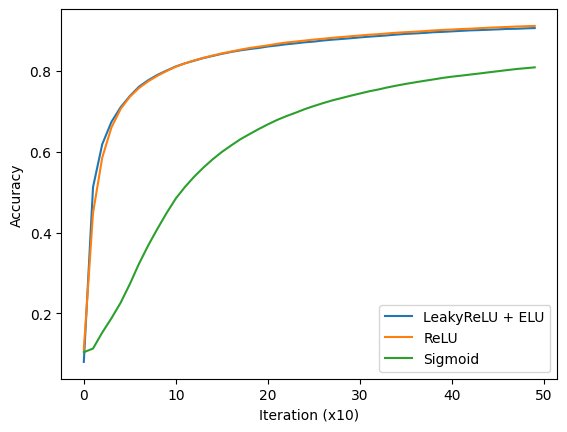

In [17]:
plt.plot(accuracy_list_leaky_elu, label='LeakyReLU + ELU')
plt.plot(accuracy_list_relu, label='ReLU')
plt.plot(accuracy_list_sigmoid, label='Sigmoid')
plt.xlabel('Iteration (x10)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
